## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

//anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

In [3]:
os.listdir(path)

['links.csv',
 'models',
 'tags.csv',
 'ratings.csv',
 'README.txt',
 'movies.csv',
 'tmp']

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [6]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [7]:
val_idxs = get_cv_idxs(len(ratings))
val_idxs

array([19090, 99678, 18455, ..., 56749, 27665, 23192])

In [8]:
wd = 2e-4  # Weight decay ~ L2 regularization.
n_factors = 50  # Dimension of embeddings.

In [9]:
cf = CollabFilterDataset.from_csv(path, csv='ratings.csv',
                                  user_name='userId', item_name='movieId', rating_name='rating')

In [10]:
learn = cf.get_learner(n_factors, val_idxs, bs=64, opt_fn=optim.Adam)

In [12]:
next(iter(learn.data.trn_dl))

[
   76
  276
  395
  548
  508
   14
  644
  163
  129
  176
  366
    2
   14
  231
  349
  212
  168
   29
  532
   16
  451
  212
  606
  508
  614
  609
  204
  167
  186
  606
  352
  608
  310
  149
  229
  207
  651
  117
  250
  172
  438
  312
  528
  327
   96
  626
  427
  651
   14
   37
  382
   66
  451
  432
  557
  528
  308
  342
  293
  470
  474
  219
  110
  619
 [torch.LongTensor of size 64], 
   940
    99
    63
  1055
  6991
  1043
   441
  1493
   750
   217
  6623
   129
  1561
  2253
  2731
  4720
  2966
   165
   121
  1147
    79
  5385
   650
  2097
  3498
  1617
  1435
    99
  2473
   626
  1077
  5100
  3782
   588
    57
   584
  5531
  2162
  1888
   713
  3121
   354
   889
  3728
   402
   204
   477
  8967
   371
  1480
   143
   174
   824
  1203
  1101
  5286
   785
   506
   394
   520
  1495
  1058
    91
   369
 [torch.LongTensor of size 64], 
  2.5000
  5.0000
  2.0000
  1.0000
  4.0000
  2.0000
  4.0000
  4.0000
  3.0000
  4.0000
  2.0000
 

In [10]:
learn.lr_find()

 72%|███████▏  | 905/1251 [00:10<00:03, 89.53it/s, loss=4.68]

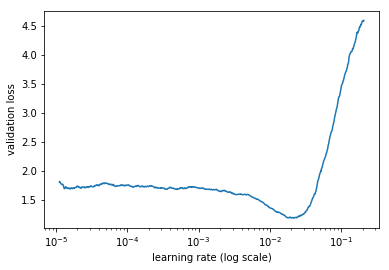

In [11]:
learn.sched.plot()

In [12]:
learn.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.783353   0.802009  
    1      0.827221   0.77908                                  
    2      0.58393    0.76508                                  
    3      0.772489   0.796604                                 
    4      0.71188    0.774063                                 
    5      0.567516   0.761564                                 
    6      0.41089    0.7625                                   


[array([0.7625])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [12]:
math.sqrt(0.757)

0.8700574693662483

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [13]:
preds = learn.predict()

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


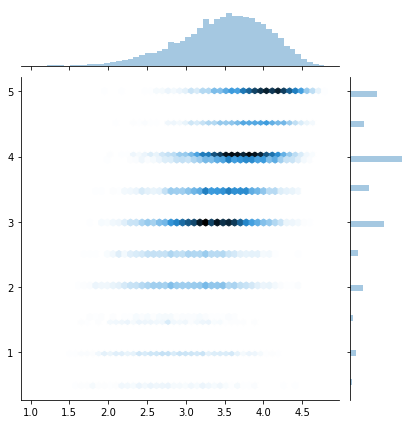

In [14]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None); # Seaborn

## Analyze results

### Movie bias

In [15]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [17]:
m=learn.model
# m.cuda()

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [18]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [19]:
movie_bias

array([[ 0.7939 ],
       [ 0.86312],
       [ 1.30499],
       ...,
       [ 0.24043],
       [-0.02345],
       [ 0.18499]], dtype=float32)

In [20]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [21]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-1.0764887, 'Battlefield Earth (2000)'),
 (-0.8358966, 'Speed 2: Cruise Control (1997)'),
 (-0.82054406, 'Wild Wild West (1999)'),
 (-0.8163259, 'Super Mario Bros. (1993)'),
 (-0.81573635, 'Anaconda (1997)'),
 (-0.77649087, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.73758316, 'Inspector Gadget (1999)'),
 (-0.73554575, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.70517737, 'Congo (1995)'),
 (-0.7049607, 'Superman III (1983)'),
 (-0.69316345, 'Batman & Robin (1997)'),
 (-0.6828344, 'Showgirls (1995)'),
 (-0.6784806, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6745511, 'Haunting, The (1999)'),
 (-0.6673242, 'Flintstones, The (1994)')]

In [22]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.0764887, 'Battlefield Earth (2000)'),
 (-0.8358966, 'Speed 2: Cruise Control (1997)'),
 (-0.82054406, 'Wild Wild West (1999)'),
 (-0.8163259, 'Super Mario Bros. (1993)'),
 (-0.81573635, 'Anaconda (1997)'),
 (-0.77649087, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.73758316, 'Inspector Gadget (1999)'),
 (-0.73554575, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.70517737, 'Congo (1995)'),
 (-0.7049607, 'Superman III (1983)'),
 (-0.69316345, 'Batman & Robin (1997)'),
 (-0.6828344, 'Showgirls (1995)'),
 (-0.6784806, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6745511, 'Haunting, The (1999)'),
 (-0.6673242, 'Flintstones, The (1994)')]

In [23]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.304986, 'Shawshank Redemption, The (1994)'),
 (1.1508006, 'Godfather, The (1972)'),
 (1.0902957, 'Usual Suspects, The (1995)'),
 (1.0332011, 'Godfather: Part II, The (1974)'),
 (0.96839815, "Schindler's List (1993)"),
 (0.9491334, '12 Angry Men (1957)'),
 (0.8878926, 'Princess Bride, The (1987)'),
 (0.882439, 'Dark Knight, The (2008)'),
 (0.8780365, 'Memento (2000)'),
 (0.87479293, 'Fargo (1996)'),
 (0.8664363, 'African Queen, The (1951)'),
 (0.8631213, 'Pulp Fiction (1994)'),
 (0.8588586, 'Silence of the Lambs, The (1991)'),
 (0.85581875, 'To Kill a Mockingbird (1962)'),
 (0.8501916, 'Matrix, The (1999)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [24]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [26]:
movie_pca.shape

(3, 3000)

In [27]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [28]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08730191, 'Armageddon (1998)'),
 (0.08107982, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.05856318, 'Outbreak (1995)'),
 (0.05669366, 'Three Musketeers, The (1993)'),
 (0.05537838, 'Pay It Forward (2000)'),
 (0.053989276, 'Gone in 60 Seconds (2000)'),
 (0.053510055, 'Waterworld (1995)'),
 (0.05316868, 'Batman Forever (1995)'),
 (0.053167008, 'X-Men (2000)'),
 (0.052771013, 'Police Academy 4: Citizens on Patrol (1987)')]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.09864248, 'Pulp Fiction (1994)'),
 (-0.085740685, 'Fargo (1996)'),
 (-0.07454481, 'Apocalypse Now (1979)'),
 (-0.0715694, 'Godfather, The (1972)'),
 (-0.07112157, 'Taxi Driver (1976)'),
 (-0.070804715, 'Being John Malkovich (1999)'),
 (-0.068588935, 'Chinatown (1974)'),
 (-0.064636305, 'Goodfellas (1990)'),
 (-0.060259376, 'Vertigo (1958)'),
 (-0.05935088, 'Deer Hunter, The (1978)')]

In [30]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [32]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.122840315, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.12203865, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.1194638, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.11067785, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.10759201,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.10658535, 'Jurassic Park (1993)'),
 (0.09696781, 'Forrest Gump (1994)'),
 (0.0959345, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.09378796, 'Die Hard (1988)'),
 (0.093547806, 'Dark Knight, The (2008)')]

In [33]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.061968442, 'Island of Dr. Moreau, The (1996)'),
 (-0.05553867, 'Alien: Resurrection (1997)'),
 (-0.05019808, 'Bringing Up Baby (1938)'),
 (-0.04971438, 'Lost Highway (1997)'),
 (-0.048591606, 'Stepford Wives, The (1975)'),
 (-0.04792034, 'Leaving Las Vegas (1995)'),
 (-0.047456346, 'Psycho (1998)'),
 (-0.04670669, 'Tank Girl (1995)'),
 (-0.045915358, 'American Psycho (2000)'),
 (-0.04530792, 'Thin Red Line, The (1998)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

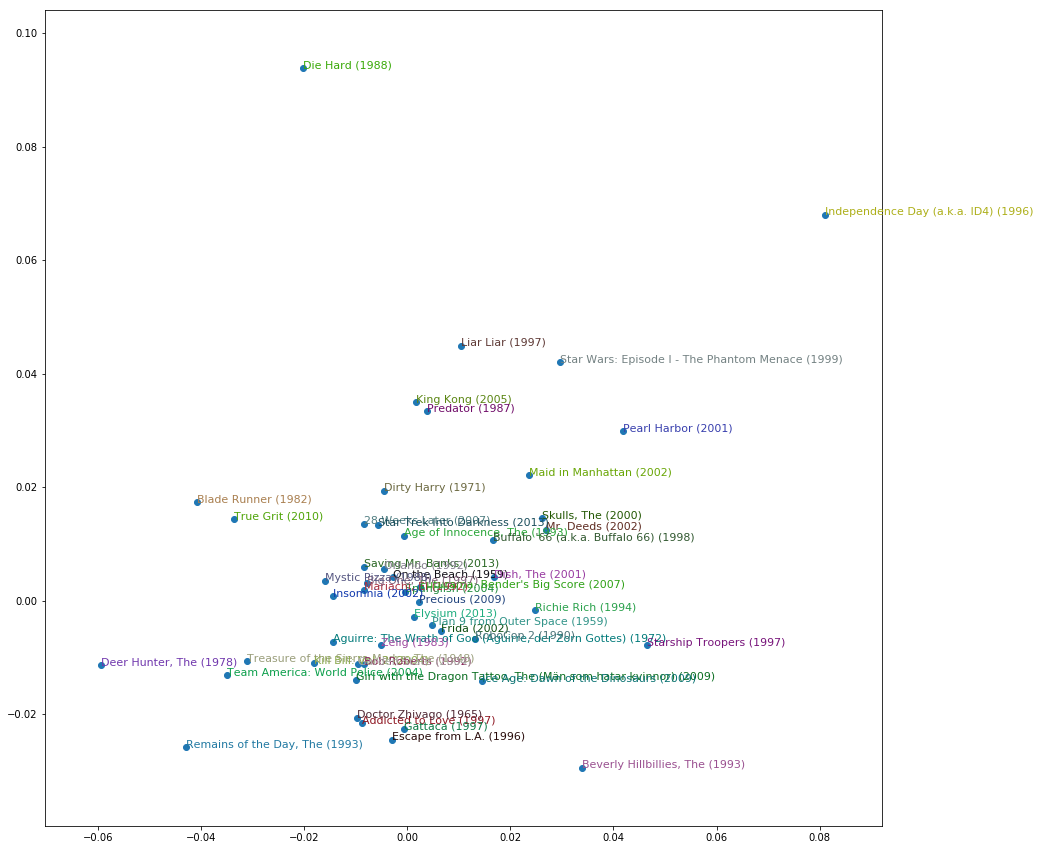

In [36]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [15]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [16]:
a * b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [17]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [18]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [19]:
model=DotProduct()

In [20]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [21]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [22]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        """
        Because we are using ColumnarModelData, which returns 
        categorical variables (cats) and continuous variables (conts),
        we define both as the parameters of the forward method.
        """
        users , movies = cats[:, 0], cats[:, 1]
        u , m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [23]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [24]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [25]:
cats_i, conts_i, y_i = next(iter(data.trn_dl))
print(cats_i.size(), conts_i.size(), y_i.size())

torch.Size([64, 2]) torch.Size([64, 1]) torch.Size([64, 1])


In [46]:
cats_i[:5, :], y_i[:5]

(
   286  1648
   431  1347
   543  5713
     2    79
   413  2686
 [torch.cuda.LongTensor of size 5x2 (GPU 0)], 
  4.5000
  5.0000
  4.5000
  3.0000
  3.0000
 [torch.cuda.FloatTensor of size 5x1 (GPU 0)])

In [26]:
print('But conts_i is all zeros!', conts_i.cpu().numpy().flatten())

But conts_i is all zeros! [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [28]:
??fit

In [29]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.58226    1.623373  
    1      1.145623   1.29829                                  
    2      0.941419   1.236578                                  



[array([1.23658])]

In [30]:
set_lrs(opt, 0.01)

In [31]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.708286   1.154373  
    1      0.68027    1.140461                                  
    2      0.663665   1.134303                                  



[array([1.1343])]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


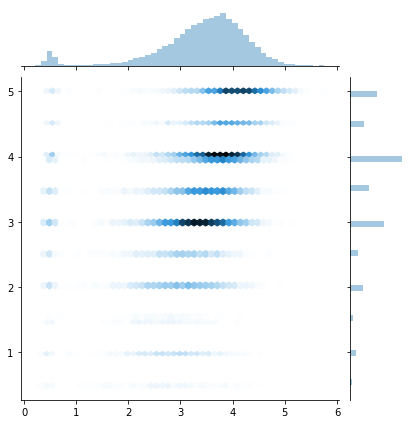

In [32]:
preds = predict(model, data.val_dl)
y = data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None); # Seaborn

### Bias

In [34]:
min_rating, max_rating = ratings.rating.min(),ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [36]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
        ## self.u = get_emb(n_users, n_factors)
        ## self.m = get_emb(n_movies, n_factors)
        ## ...
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        
        # Output between min_rating and max_rating
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

In [37]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
    # .cuda() to put model into GPU.  Must do it manually when there is no learner.
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [38]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.852231   0.835096  
    1      0.786719   0.815688                                  
    2      0.799068   0.811                                     



[array([0.811])]

In [39]:
set_lrs(opt, 1e-2)

In [40]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.735851   0.803269  
    1      0.725536   0.801835                                  
    2      0.717525   0.800937                                  



[array([0.80094])]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


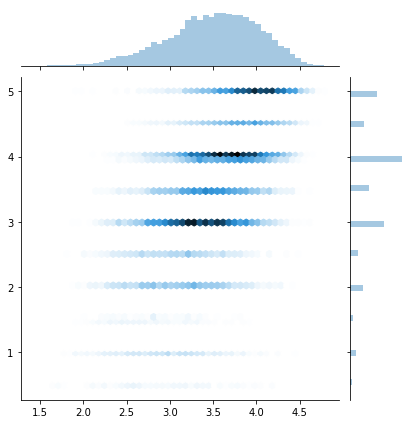

In [41]:
preds = predict(model, data.val_dl)
y = data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None); # Seaborn

### Mini net

In [73]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users, movies = cats[:,0], cats[:,1]
        x = self.drop1(torch.cat([self.u(users), self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [74]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [75]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.901133   0.809414  
    1      0.802818   0.794507                                  
    2      0.806705   0.791228                                  



[array([0.79123])]

In [76]:
set_lrs(opt, 1e-3)

In [77]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.781725   0.794516  
    1      0.775554   0.791192                                  
    2      0.762681   0.790042                                  



[array([0.79004])]